# TP1

### Requisitos:

- Usar a package criptography
- Usar o package asyncio para criar comunicações cliente-servidor
- Usar o SHAKE-256 como cifra AEAD em modo XOFHash

### O que é o "Modelo Sponge"

> O modelo Sponge surge dada a dificuldade de construir uma boa função de compressão unidirecional, assim, este substitui a compressão por uma permutação.
> O SHA3 introduz esta ideia através do uso do uso do sponge model

Em relação ao modelo MD:
- Permutações são mais simples de contruir e mais eficientes que compressões
- O output da função de "hash" é fixo mas esse tamanho é um parametro da operação, ou seja, pode variar entre duas execuções do mesmo "hash"


Esta ultima caracteristica dá a designação de XOF(“eXtendable Output Function”) à função de hash

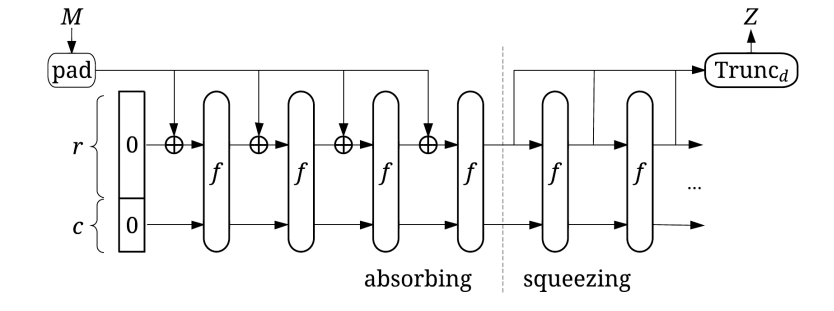

O nome Sponge provém da computação ser feita em duas fases:

- **Absorb** :
    - M é padded e dividida em segmentos de tamanho r (rate);
    - O plaintext $ P ≡ p0 ∥p1 ∥ … ∥pm $ é absorvido num bloco de estado com tamanho b >> r;
    - O resto do bloco, de tamanho $ c = b - r $ , designa-se por capacidade (metade dos bits da capacidade é o coeficiente de segurança desta arquitetura);
    - O bloco de estados é inicializado com um vetor vi nas primeiras r posições e zeros na capacidade;
    - Em cada iteração é lido um bloco do "plaintext" que é somado aos primeiros r bits do estados e aplica-se então uma permutação $ f: {{0,1}}^b → {{0, 1}}^b $ à totalidade do estado.
<div class="alert alert-block alert-info">
<b>Tip:</b> Coeficiente de Segurança é diferença entre a complexidade de um ataque teórico e a segurança oferecida por um sistema criptográfico.
</div>

- **Squeeze**
    - Através do estado construída na fase de Absorb,são extraídos segmentos $ ti $ do "output" e ao mesmo tempo o estado continua a ser transformado com $ f $;
    - A cada extração são retirados r bits do estado;
    - Concatenando todos os segmentos $ ti $ constroi-se a tag
    - Para determinar o parametro $ ℓ $ faz-se $ ℓ = ⌈ ∣tag∣/r⌉ $
    - $ f $ define o algoritmo **Keccaq** , que usa $ b = 1600 bits $
    - Como vamos usar **SHAKE-256** as propriedades são as seguintes:
        - output: variável
        - rate: 1088
        - capacity: 515
        - 1st pre-image security: 256

### Cifra AEAD usando o modelo “sponge”

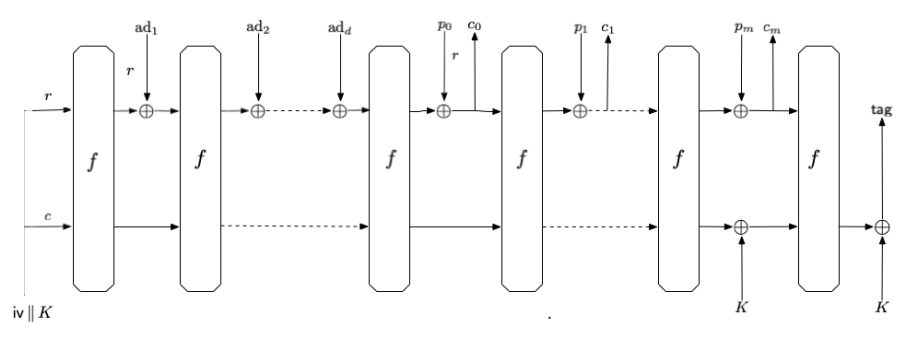

Como vemos pela imagem, o modelo Sponge pode ser usado como *cifra autenticada com dados associados*
- Na primeira fase são absorvidos os segmentos que descrevem os dados associados;
- Na segunda fase usa-se uma cifra de Vernam que recebe $pi$ sucessivos de um "plaintext", soma-os com r bits do estado e devolve os segmentos ci do criptograma;
- Após todo o processamento do plaintext, existe uma permutação para construir a tag de autenticação final
- A chave $ K $ da cifra aparece na inicialização do 1º valor do estados e aparece antes e depois da ultima aplicação da permutação

# Exercicio 1a
O problema presente no execicio 1a é a implementação de uma comunicação cliente-servidor utilizando o package asyncio.
Para a implementação do execicio foram criados dois ficheiros python individuais, um para o receiver e outro para o emitter.

## Emitter
Para o emitter o funcionamento passa por numa primeira fase abrir conecção ao servidor atráves de um ip e de uma porta que se encontram hardcoded.

<b>Utilização do emitter:</b>
<pre style="background:#300924;color:white;padding:10px;border-radius:5px;">
$ python3 emitter.py chave
</pre>

Se a ligação for estabelicida então o emitter entra em um modo de envio de mensagens onde é possivel inserir no terminal a mensagem a ser enviada para o servidor, caso contrario é apresentado um erro no terminal que indica que a ligação não foi estabelecida.

<b> Enviar mensagem: </b>
<pre style="background:#300924;color:white;padding:10px;border-radius:5px;">
$ [CLIENT] Enviar mensagem para o servidor: inserir mensagem
</pre>

Assim que uma mensagem é enviada pelo emitter, imediatamente a seguir ele aguarda pela resposta do servidor.

## Receiver
Para o receiver o funcionamento passa por começar o serviço no ip e porta que se encontram hardcoded, ficando a servir por tempo ilimitado. O servidor suporta multiplos clientes e responde a cada um de forma individual.

Quando o servidor recebe uma mensagem de um cliente ele exibe no terminal a mensagem recebida com as informações do cliente, e envia como resposta exatamente a mesma mensagem que foi recebida.
Se o cliente fechar a comunicação o servidor continua a servir no mesmo ip/porta e aguarda por novos clientes.
Utilização do emitter:

<b>Utilização do receiver:</b>
<pre style="background:#300924;color:white;padding:10px;border-radius:5px;">
$ python3 emitter.py chave
</pre>

<b>Nota:</b> Na secção do exercicio 1c encontra-se explicado como foi realizada a integração com os serviços de KDF e AEAD e as modificações realizadas no emitter e receiver.



# Exercicio 1b
Para o exercicio 1b pretende-se implementar uma cifra AEAD utilizando o shake-256 em modo XOFHash.

Para a resolução deste execicio foi criado o ficheiro AEAD.py que contém a implementação da cifra em uma classe.
 
O modelo sponge utilizado para implementar a cifra AEAD foi o seguinte

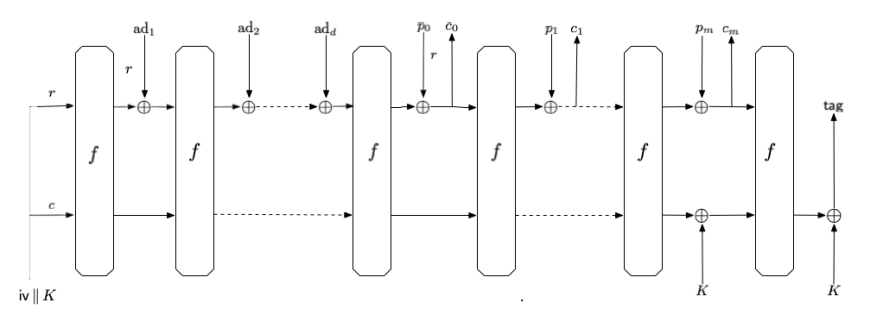

Neste modelo o rate é um IV, ou seja, um nounce gerado aleatoriamente. 

A capacidade do modelo é a chave, em que metade dos bits da chave são o coeficiente de segurança.

## Padding do plaintext e associated data
Para o padding decidimos implementar dois tipos diferentes:
PKCS7 e o zero padding.
O padding que será utilizado pode ser escolhido.

### PKCS7
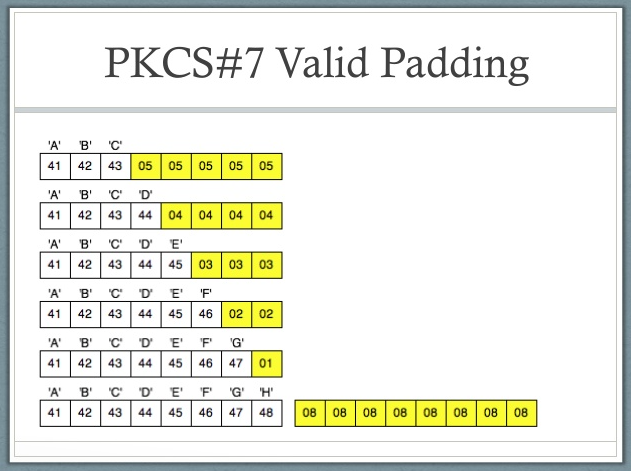

O PKCS7 cria um padding que faz com que o input seja multiplo do tamanho de um bloco, o que é uma propriedade util para o contexto da implementação do sponge.

O PCKS7 adiciona bytes de padding que indicam quantos bytes foram inseridos, o que permite uma remoção fácil do padding.

No entanto a vantagem do pkcs7 mais importante é que ele permite detetar corrupção ou modificação dos dados, isto porque, se os dados forem truncados é possivel detetar.

Ou seja este padding é seguro e permite descobrir no processo de decifragem se os dados foram modificados sem a necessidade de verificar as tags de cifragem e decifragem. 

No entanto não remove a necessidade da comparação de tags, apenas fornece uma segurança extra que é util. 

## Absorve
A fase de absorve funciona da seguinte forma:
O rate e a capacidade são concatenados formando o estado da cifra, esse estado é passado pela função f (shake-256) que irá fornecer como output uma hash.
Apartir dos primeiros rate bits do estado obtido após a aplicação da função f é possivel extrair o novo rate.
Com o novo rate é realizado um OTP com um bloco 

### Zero Padding
Com o zero padding é inserido um bit 1 no final do texto e são adicionados bits 0 até que o tamanho pretendido seja obtido


# Bibliografia utilizada:
Patra, A., & Sinha Roy, S. (Eds.). (2021). *Progress in Cryptology – INDOCRYPT 2021: 22nd International Conference on Cryptology in India, Jaipur, India, December 12–15, 2021, Proceedings* (Vol. 13143). Springer.  
Disponível em: [https://doi.org/10.1007/978-3-030-92518-5](https://doi.org/10.1007/978-3-030-92518-5)